# Exploratory Data Analysis para datos de Precios


## Importando Librerías


In [92]:
import pandas as pd
from azure.storage.blob import BlobServiceClient
import io
import os
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [93]:
pd.options.display.max_columns = 100

In [94]:
load_dotenv(find_dotenv())

True

## Leyendo Datos


In [95]:
def obtain_content_of_blob(connection_string, container_name, file_name):
    """
    Esta función crea una conexión a un archivo específico almacenado en blob Storage y retorna su contenido
    """
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    container_client = blob_service_client.get_container_client(container_name)
    blob_client = container_client.get_blob_client(file_name)
    blob_stream = blob_client.download_blob().readall()
    blob_file = io.BytesIO(blob_stream)
    return blob_file

In [96]:
connection_string = os.getenv("AZ_CONNECTION_STRING")
container_name = "raw/EnergySuiteData/precios/aire/"

In [97]:
df_precios = pd.read_csv(
    obtain_content_of_blob(connection_string, container_name, "AireSup-Prices.csv"),
    delimiter=";",
)

print(df_precios.shape)
print(df_precios.dtypes)
df_precios.head()

(21264, 9)
Id              object
Date            object
Period           int64
Version          int64
MarketType      object
ProductType     object
ConceptId       object
Value          float64
UpLoadId       float64
dtype: object


Id                     Date  Period  \
0  7459BD0B-E48E-487A-B7D9-01E11783FAF0  2023-09-30 00:00:00.000      20   
1  25E1062D-603C-432C-BAA5-07C4013A78FE  2023-09-30 00:00:00.000      19   
2  BABD0C9A-111E-4D7A-A4B7-0AB310F6D4A5  2023-09-30 00:00:00.000       8   
3  5109AA0B-B546-408C-B9A5-1C0FF634D91A  2023-09-30 00:00:00.000       2   
4  F7CCDBA3-1710-4BF7-8BEE-28826207E2FA  2023-09-30 00:00:00.000      11   

   Version MarketType ProductType ConceptId        Value  UpLoadId  
0        4   TMerEner      TPEner      PBNA  1062.184761       NaN  
1        4   TMerEner      TPEner      PBNA  1062.185761       NaN  
2        4   TMerEner      TPEner      PBNA  1008.944761       NaN  
3        4   TMerEner      TPEner      PBNA  1008.945761       NaN  
4        4   TMerEner      TPEner      PBNA  1062.085761       NaN

## Preprocesando los datos


### Analizando contenido y relevancia de las columnas


In [98]:
df_precios.sort_values(by="Period", ascending=True).Period.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [99]:
df_precios.Version.unique()

array([4, 5, 6, 3])

In [100]:
df_precios.MarketType.unique()

array(['TMerEner'], dtype=object)

In [101]:
df_precios.Period.unique()

array([20, 19,  8,  2, 11, 17, 13, 24, 22, 15,  3, 10,  5,  6, 23, 12, 21,
        4, 16, 14,  9,  1,  7, 18,  0])

In [102]:
df_precios.ProductType.unique()

array(['TPEner'], dtype=object)

In [103]:
df_precios.ConceptId.unique()

array(['PBNA', 'DSNTF', 'DSNTM', 'INDIPC', 'INDIPP', 'MC'], dtype=object)

In [104]:
df_precios.groupby(["ConceptId"])[["ConceptId"]].count()

ConceptId
ConceptId           
DSNTF           1690
DSNTM            191
INDIPC            14
INDIPP            15
MC                14
PBNA           19340

In [105]:
px.line(
    df_precios.groupby(["ConceptId", "Date"])[["Value"]].mean().reset_index(),
    x="Date",
    y="Value",
    color="ConceptId",
)

Se identifican diferentes Conceptos para el valor de la energía, según la regla de negocio indicada, solo se deja el concepto `PBNA`, que hace referencia al **Precio Bruto Nacional** al que fue comprada la energía en cada fecha por el cliente A-ire


In [106]:
df_precios.UpLoadId.unique()

array([nan])

### Cambios a aplicar:

- Filtrado de DataFrame: `ConceptId`=`PBNA`
  -Filtrado de columnas: Se identifica que las únicas columnas relevantes son `Date`, `Period`, `ConceptId` (solo para hacer el filtro, luego deja de ser relevante) y `value`


In [107]:
columns_to_keep = ["Date", "Period", "ConceptId", "Value"]

# Filtrando dataframe
df_precios_curated = df_precios[columns_to_keep]  # filtrando filas
print("Sin filtrar filas ", df_precios_curated.shape)
df_precios_curated = df_precios_curated[
    df_precios_curated["ConceptId"] == "PBNA"
].reset_index(
    drop=True
)  # filtrando columnas
print("Filtrando por conceptID ", df_precios_curated.shape)
df_precios_curated.head()

Sin filtrar filas  (21264, 4)
Filtrando por conceptID  (19340, 4)


Date  Period ConceptId        Value
0  2023-09-30 00:00:00.000      20      PBNA  1062.184761
1  2023-09-30 00:00:00.000      19      PBNA  1062.185761
2  2023-09-30 00:00:00.000       8      PBNA  1008.944761
3  2023-09-30 00:00:00.000       2      PBNA  1008.945761
4  2023-09-30 00:00:00.000      11      PBNA  1062.085761

### Formateando las columnas Date y Period.

La columna Date hace referencia a la fecha y la columna Period, hace referencia a un periodo de minutos del día, se van a realizar las transformaciones necesarias para concervir el Period en la hora del día.


In [108]:
print(len(df_precios.sort_values(by="Period", ascending=True).Period.unique()))
df_precios.sort_values(by="Period", ascending=True).Period.unique()

25


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

Cada `Period` hace referencia a una hora del día.


In [109]:
# Define a function to convert periods to hours and minutes
def period_to_time(period):
    if period == 0:
        return "00:00"
    elif period == 24:
        return "00:00"
    else:
        total_minutes = (period) * 60
        hours = total_minutes // 60
        minutes = total_minutes % 60
        return f"{hours:02d}:{minutes:02d}"

In [110]:
df_precios_curated["Date"] = df_precios_curated["Date"].apply(lambda x: x.split(" ")[0])
df_precios_curated["Hour"] = df_precios["Period"].apply(period_to_time)
df_precios_curated["Datetime"] = (
    df_precios_curated["Date"] + " " + df_precios_curated["Hour"]
)
df_precios_curated["Datetime"] = pd.to_datetime(df_precios_curated["Datetime"])
df_precios_curated.head()

Date  Period ConceptId        Value   Hour            Datetime
0  2023-09-30      20      PBNA  1062.184761  20:00 2023-09-30 20:00:00
1  2023-09-30      19      PBNA  1062.185761  19:00 2023-09-30 19:00:00
2  2023-09-30       8      PBNA  1008.944761  08:00 2023-09-30 08:00:00
3  2023-09-30       2      PBNA  1008.945761  02:00 2023-09-30 02:00:00
4  2023-09-30      11      PBNA  1062.085761  11:00 2023-09-30 11:00:00

### Conservando columnas relevantes

Después de filtrar las filas y formatear la fecha y hora, las columnas `Period` y `ConceptId` dejan de ser relevantes.


In [111]:
df_precios_curated = df_precios_curated.drop(columns=(["Period", "ConceptId"]))
df_precios_curated.head()

Date        Value   Hour            Datetime
0  2023-09-30  1062.184761  20:00 2023-09-30 20:00:00
1  2023-09-30  1062.185761  19:00 2023-09-30 19:00:00
2  2023-09-30  1008.944761  08:00 2023-09-30 08:00:00
3  2023-09-30  1008.945761  02:00 2023-09-30 02:00:00
4  2023-09-30  1062.085761  11:00 2023-09-30 11:00:00

## Analizando la Calidad de los datos.


### Análisis de Tipos de Datos


In [112]:
df_precios_curated.dtypes

Date                object
Value              float64
Hour                object
Datetime    datetime64[ns]
dtype: object

In [113]:
df_precios_curated["Date"] = pd.to_datetime(df_precios_curated["Date"])
print(df_precios_curated.dtypes)
df_precios_curated.head()

Date        datetime64[ns]
Value              float64
Hour                object
Datetime    datetime64[ns]
dtype: object


Date        Value   Hour            Datetime
0 2023-09-30  1062.184761  20:00 2023-09-30 20:00:00
1 2023-09-30  1062.185761  19:00 2023-09-30 19:00:00
2 2023-09-30  1008.944761  08:00 2023-09-30 08:00:00
3 2023-09-30  1008.945761  02:00 2023-09-30 02:00:00
4 2023-09-30  1062.085761  11:00 2023-09-30 11:00:00

In [114]:
df_precios_curated["Year"] = df_precios_curated["Date"].dt.year.astype(
    str
)  # Creando columna Year
df_precios_curated["Month"] = (
    df_precios_curated["Date"].astype(str).apply(lambda x: x.split("-")[1])
)  # Creando columna Month
df_precios_curated["Year-Month"] = (
    df_precios_curated["Year"] + "-" + df_precios_curated["Month"]
)  # Creando columna year-Month
df_precios_curated.rename(
    columns={"Value": "Precio"}, inplace=True
)  # Reemplazando Value por Precio
print(df_precios_curated.dtypes)
df_precios_curated.head()

Date          datetime64[ns]
Precio               float64
Hour                  object
Datetime      datetime64[ns]
Year                  object
Month                 object
Year-Month            object
dtype: object


Date       Precio   Hour            Datetime  Year Month Year-Month
0 2023-09-30  1062.184761  20:00 2023-09-30 20:00:00  2023    09    2023-09
1 2023-09-30  1062.185761  19:00 2023-09-30 19:00:00  2023    09    2023-09
2 2023-09-30  1008.944761  08:00 2023-09-30 08:00:00  2023    09    2023-09
3 2023-09-30  1008.945761  02:00 2023-09-30 02:00:00  2023    09    2023-09
4 2023-09-30  1062.085761  11:00 2023-09-30 11:00:00  2023    09    2023-09

### Buscando Anomalías en `Value` o en `Date`


#### Buscando Missing Values


In [115]:
# Date
df_precios_curated.Date.isna().value_counts()

Date
False    19340
Name: count, dtype: int64

In [116]:
# Precio
df_precios_curated.Precio.isna().value_counts()

Precio
False    19340
Name: count, dtype: int64

No se identifican valores faltantes en las columnas de fecha y precio


#### Gráficando distribución de `Precio`


In [117]:
px.box(
    df_precios_curated, x="Precio", title="Distribución del Precio de la Energia Kb/h"
)

No se identifican Valores Negativos o Atipicos en la columna `value`


#### Gráficando distribución de `Date`


In [118]:
px.box(df_precios_curated, x="Date", title="Distribución de Date")

#### Gráficando distribución de `DateTime`


In [119]:
px.box(df_precios_curated, x="Datetime", title="Distribución de Datetime")

No se identifican fechas incoherentes. Queda claro que hay datos desde el **01-10-2021** hasta **30-09-2023**


## Agregando datos y Realizando Analisis Exploratorio de Datos

Dado que los datos exógenos están a nivel de día, se van a agrupar los valores de precios de la energía para tener solo un dato por día, para esto se va a calcular el promedio por Fecha.


In [120]:
df_precio_dia = (
    df_precios_curated.groupby(["Date", "Year", "Month", "Year-Month"])[["Precio"]]
    .mean()
    .reset_index()
)
df_precio_dia

Date  Year Month Year-Month       Precio
0   2021-10-01  2021    10    2021-10   216.929726
1   2021-10-02  2021    10    2021-10   256.940174
2   2021-10-03  2021    10    2021-10   282.065065
3   2021-10-04  2021    10    2021-10   286.526116
4   2021-10-05  2021    10    2021-10   278.157325
..         ...   ...   ...        ...          ...
639 2023-09-26  2023    09    2023-09  1061.527174
640 2023-09-27  2023    09    2023-09  1041.160576
641 2023-09-28  2023    09    2023-09  1042.769645
642 2023-09-29  2023    09    2023-09  1030.807224
643 2023-09-30  2023    09    2023-09  1012.220969

[644 rows x 5 columns]

### Analizando consistencia temportal de los datos


In [121]:
df_precio_mes = (
    df_precios_curated.groupby(["Year", "Month", "Year-Month"])[["Precio"]]
    .mean()
    .reset_index()
)
df_precio_mes.head()

Year Month Year-Month      Precio
0  2021    10    2021-10  221.548924
1  2021    11    2021-11  225.856837
2  2021    12    2021-12  112.377610
3  2022    02    2022-02  399.121579
4  2022    04    2022-04  143.771936

In [122]:
fig = px.bar(
    df_precio_mes,
    x="Year-Month",
    y="Precio",
    title="Precio promedio de la Energía Kb/h por Year-Month",
)
fig.show()

Se identifica que para los periodos de **2022-01** y **2022-03** no hay registros del precio de la energía. Por lo tanto, se aplicarán métodos de imputación de datos para que el proceso de modelado sea más eficiente.


### Analizando la tendencia del Precio de la energía Diario


In [123]:
px.box(
    df_precio_dia,
    y="Precio",
    x="Year",
    title="Distribución del Precio de la Energia Kb/h por Year",
    color="Year",
)

In [124]:
px.line(
    df_precio_dia,
    y="Precio",
    x="Date",
    title="Evolución precio de la energía",
    color="Year",
)

Se puede evidenciar una tendencia creciente en el precio de la energía desde agosto de 2022, llegando a niveles máximos en septiembre de 2023. También se nota que puede existir un comportamiento cíclico, por lo que se va a analizar más a detalle si existen mess donde usualmente sube más el precio


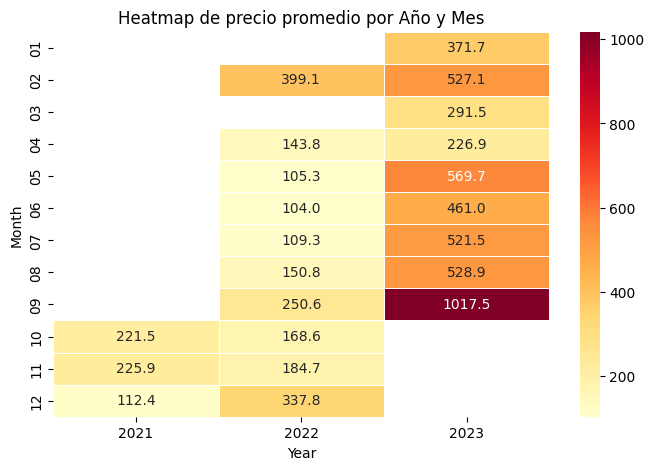

In [125]:
heatmap_data = df_precio_dia.pivot_table(
    columns="Year", index="Month", values="Precio", aggfunc="mean"
)

# Create a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap de precio promedio por Año y Mes")
plt.show()

In [126]:
df_precio_dia

Date  Year Month Year-Month       Precio
0   2021-10-01  2021    10    2021-10   216.929726
1   2021-10-02  2021    10    2021-10   256.940174
2   2021-10-03  2021    10    2021-10   282.065065
3   2021-10-04  2021    10    2021-10   286.526116
4   2021-10-05  2021    10    2021-10   278.157325
..         ...   ...   ...        ...          ...
639 2023-09-26  2023    09    2023-09  1061.527174
640 2023-09-27  2023    09    2023-09  1041.160576
641 2023-09-28  2023    09    2023-09  1042.769645
642 2023-09-29  2023    09    2023-09  1030.807224
643 2023-09-30  2023    09    2023-09  1012.220969

[644 rows x 5 columns]

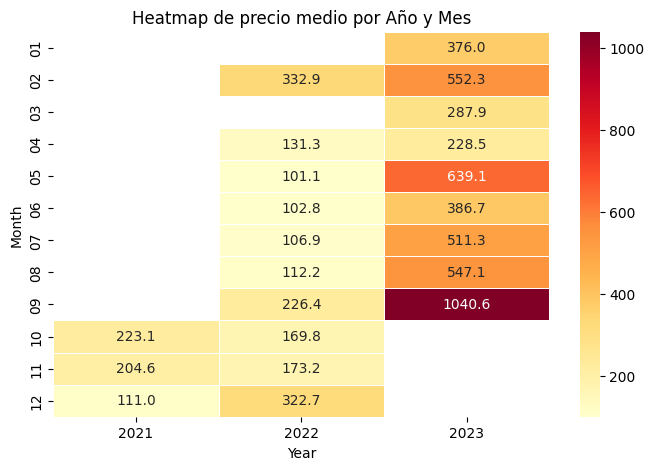

In [127]:
heatmap_data = df_precio_dia.pivot_table(
    columns="Year", index="Month", values="Precio", aggfunc="median"
)

# Create a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap de precio medio por Año y Mes")
plt.show()

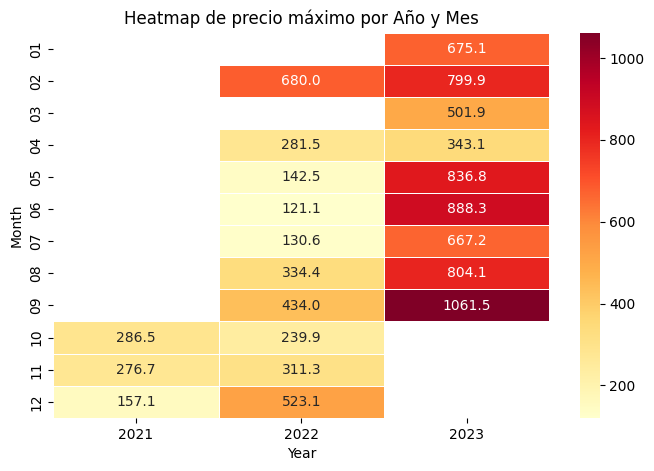

In [128]:
heatmap_data = df_precio_dia.pivot_table(
    columns="Year", index="Month", values="Precio", aggfunc="max"
)

# Create a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap de precio máximo por Año y Mes")
plt.show()

In [129]:
heatmap_data = df_precio_dia.pivot_table(
    columns="Year", index="Month", values="Precio", aggfunc="min"
)

# Create a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap de precio mínimo por Año y Mes")
plt.show()

#### Analizando tendencias por días del mes, por cada año


In [130]:
df_precio_dia["Day"] = (
    df_precio_dia["Date"].astype(str).apply(lambda x: x.split("-")[2])
)
df_precio_dia.head()

Date  Year Month Year-Month      Precio Day
0 2021-10-01  2021    10    2021-10  216.929726  01
1 2021-10-02  2021    10    2021-10  256.940174  02
2 2021-10-03  2021    10    2021-10  282.065065  03
3 2021-10-04  2021    10    2021-10  286.526116  04
4 2021-10-05  2021    10    2021-10  278.157325  05

In [131]:
def crear_heatmap_precio_dia_mes_para_un_año(df, year):
    df = df[df["Year"] == year]
    df_pivoted = df.pivot_table(
        columns="Month", index="Day", values="Precio", aggfunc="mean"
    )

    # Create a heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(df_pivoted, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5)
    plt.title(f"Heatmap de precio promedio por día y Mes para {year}")
    plt.show()

In [132]:
crear_heatmap_precio_dia_mes_para_un_año(df_precio_dia, "2021")

In [133]:
crear_heatmap_precio_dia_mes_para_un_año(df_precio_dia, "2022")

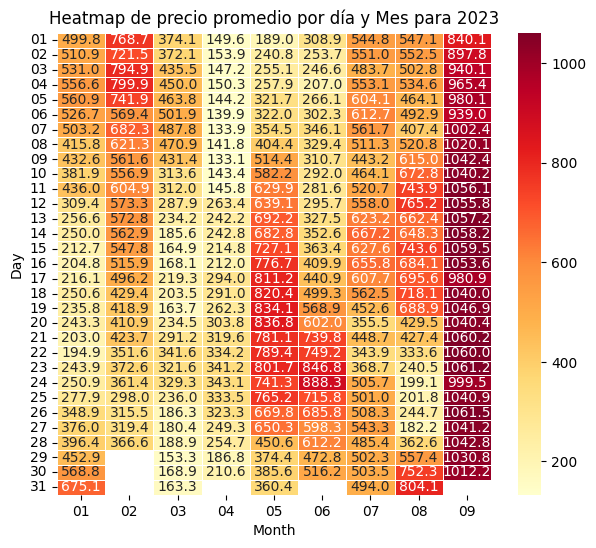

In [134]:
crear_heatmap_precio_dia_mes_para_un_año(df_precio_dia, "2023")

In [135]:
df_precio_dia.rename(columns={"Precio": "energy_price"}, inplace=True)

In [136]:
df_precio_dia[["Date", "energy_price"]].to_csv("processed_tables/precios.csv", index=False)